Input: csv file (nframe*video, 75+4)


In [1]:
import pandas as pd
import math 
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/assistive_robot_dataset/csv

/content/drive/.shortcut-targets-by-id/1d-Lf_YrIAO2cuhmL3nYF6MWqFgeNAJs8/assistive_robot_dataset/csv


The labels are pre splitted into `train.txt`, `dev.txt`, and `test.txt`. The data distribution is shown below: 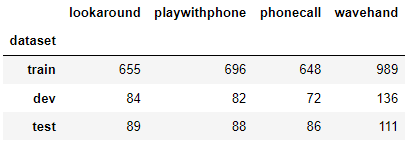

Use the data_loader function to load the train, dev, test set from Google Drive.

In [4]:
def data_loader(csv_full_path, txt_folder):
    """[summary]

    Args:
        csv_full_path (str): path to the csv file containing all the data
        txt_folder (str): path to the folder containing the txt file for train, dev, test split
    Returns: 
        3 pd.DataFrames; train, dev, test set
    """
    df = pd.read_csv(csv_full_path)

    with open(f"{txt_folder}/train.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in train set: {len(folder_names)}")
        df_train = df[df["folder_name"].isin(folder_names)]

    with open(f"{txt_folder}/dev.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in dev set: {len(folder_names)}")
        df_dev = df[df["folder_name"].isin(folder_names)]
        
    with open(f"{txt_folder}/test.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in test set: {len(folder_names)}")
        df_test = df[df["folder_name"].isin(folder_names)]

    return df_train, df_dev, df_test

train, dev, test = data_loader("all_data.csv", "train_dev_test_split")

data points in train set: 2988
data points in dev set: 374
data points in test set: 374


In [5]:
# The labels you want to change
LABEL_DICT = {'stand_look': 'lookaround'}

In [6]:
raw_df = pd.read_csv("all_data.csv")

raw_df

,folder_name,frame_num,height,width,x0,y0,c0,x1,y1,c1,x2,y2,c2,x3,y3,c3,x4,y4,c4,x5,y5,c5,x6,y6,c6,x7,y7,c7,x8,y8,c8,x9,y9,c9,x10,y10,c10,x11,y11,c11,x12,y12,c12,x13,y13,c13,x14,y14,c14,x15,y15,c15,x16,y16,c16,x17,y17,c17,x18,y18,c18,x19,y19,c19,x20,y20,c20,x21,y21,c21,x22,y22,c22,x23,y23,c23,x24,y24,c24
0,kth_wavehand_100_0_0,2,216.0,110.0,0.076636,-0.314090,0.751668,0.076667,-0.249313,0.836159,-0.108586,-0.252130,0.728457,-0.235775,-0.141464,0.724725,-0.394870,-0.057755,0.582226,0.257010,-0.244039,0.708746,0.368423,-0.130682,0.578228,0.474327,-0.049728,0.270695,0.034335,0.028472,0.692086,-0.076763,0.023116,0.614507,-0.061114,0.206690,0.679213,-0.060971,0.382069,0.677863,0.150904,0.031181,0.663135,0.113648,0.220060,0.735982,0.077070,0.395509,0.694175,0.044991,-0.333107,0.746490,0.113793,-0.327697,0.747913,-0.002623,-0.335634,0.537447,0.161846,-0.322317,0.703835,0.066284,0.427903,0.564592,0.113917,0.425222,0.617639,0.071393,0.403630,0.489165,-0.087481,0.417181,0.653374,-0.124488,0.411745,0.619981,-0.044924,0.398162,0.563505
1,kth_wavehand_100_0_0,4,214.0,109.0,0.071542,-0.314253,0.856080,0.066173,-0.249471,0.821139,-0.108654,-0.252168,0.734470,-0.331135,-0.184666,0.717643,-0.482309,-0.141441,0.303764,0.240898,-0.249304,0.731349,0.479560,-0.149563,0.521376,-0.500000,-0.500000,0.000000,0.023738,0.025841,0.637923,-0.092902,0.017822,0.638657,-0.092827,0.204056,0.761383,-0.087452,0.379411,0.703542,0.124643,0.028607,0.634035,0.092794,0.206799,0.693582,0.071729,0.387500,0.680938,0.034648,-0.335656,0.852793,0.108476,-0.333077,0.839061,-0.013331,-0.335751,0.871002,0.156253,-0.332964,0.809088,0.066181,0.419911,0.519080,0.113762,0.417262,0.603388,0.066170,0.398355,0.441447,-0.098039,0.417252,0.622006,-0.135118,0.414425,0.626818,-0.060883,0.395598,0.513954
2,kth_wavehand_100_0_0,6,211.0,108.0,0.073964,-0.317030,0.789007,0.073789,-0.249444,0.848997,-0.100144,-0.252134,0.728054,-0.358405,-0.217113,0.533993,-0.482329,-0.211739,0.153819,0.247640,-0.249353,0.695348,-0.500000,-0.203626,0.455474,-0.500000,-0.500000,0.000000,0.031706,0.020289,0.649969,-0.073824,0.014882,0.600840,-0.058214,0.203645,0.767651,-0.057969,0.376417,0.710993,0.152656,0.025668,0.634992,0.115895,0.219806,0.724736,0.094896,0.384384,0.646666,0.057858,-0.338401,0.797224,0.110843,-0.335826,0.845386,0.010501,-0.335759,0.640917,0.163384,-0.332990,0.784339,0.073922,0.419550,0.572210,0.126513,0.419427,0.596211,0.073800,0.397834,0.497772,-0.089562,0.424834,0.642399,-0.115993,0.416825,0.649784,-0.026382,0.395118,0.529411
3,kth_wavehand_100_0_0,8,211.0,107.0,0.079741,-0.303161,0.721383,0.079970,-0.230344,0.804855,-0.095906,-0.243775,0.648053,-0.383441,-0.254507,0.522951,-0.482147,-0.281533,0.182786,0.255782,-0.227487,0.605175,-0.500000,-0.235645,0.251792,-0.500000,-0.500000,0.000000,0.037487,0.029118,0.673069,-0.063964,0.026327,0.599248,-0.053493,0.215445,0.739303,-0.053244,0.390972,0.672539,0.159650,0.034460,0.642853,0.122475,0.223597,0.744778,0.101268,0.388294,0.599642,0.058507,-0.319478,0.725258,0.117138,-0.316745,0.769288,0.005469,-0.322139,0.517196,0.170373,-0.314037,0.689096,0.058552,0.428754,0.519222,0.117043,0.428749,0.547151,0.111724,0.399147,0.408574,-0.079964,0.431502,0.625009,-0.111843,0.420725,0.635755,-0.021378,0.401735,0.462392
4,kth_wavehand_100_0_0,10,211.0,108.0,0.073919,-0.311545,0.674381,0.068403,-0.252145,0.786579,-0.126432,-0.252267,0.680893,-0.347729,-0.306070,0.544742,-0.482350,-0.360085,0.322478,0.242592,-0.252073,0.619659,-0.500000,-0.270988,0.327266,-0.500000,-0.500000,0.000000,0.031739,0.012209,0.652931,-0.078954,0.009441,0.597789,-0.058245,0.200972,0.769491,-0.058009,0.370858,0.697048,0.152703,0.020242,0.625571,0.115826,0.209071,0.737129,0.079241,0.373697,0.689715,0.047345,-0.333006,0.666065,0.110705,-0.330425,0.688581,-0.010584,-0.327704,0.629321,0.158281,-0.324967,0.542373,0.068374,0.416839,0.652617,0.110868,0.414109,0.678783,0.068536,0.387114,0.502967,-0.084301,0.414095,0.645206,-0.115864,0.403265,0.651933,-0.031592,0.379019,0.491005
...,...,...,...,..

## count for each dataset

In [7]:
from re import search
unique_folder = raw_df[["folder_name"]].drop_duplicates("folder_name")
kth_folder = [f for f in unique_folder["folder_name"] if search("kth_", f)]

In [8]:
len(kth_folder)

452

In [9]:
ntu_folder = [f for f in unique_folder["folder_name"] if search("ntu_", f)]
len(ntu_folder)

2260

In [10]:
len(unique_folder) - len(kth_folder) - len(ntu_folder)

1024

## Continue

In [11]:
def get_label(folder_name, label_dict=None):
  '''
  find the match between name and number
  For example, 
  1. when folder_name is "jy_phonecall_10_0", returns "phonecall"
  2. when folder_name is "wc_stand_look_2_0", returns "stand_look"

  label_dict stores a mapping of raw label to modified label
  When label_dict is passed, the function returns a new modified label based on label_dict
  '''
  label = re.search('_(.+?)_\d+', folder_name).group(1)
  if label_dict != None and label in label_dict:
    return label_dict[label]
  return label

In [12]:
# The raw labels without modification 
raw_df['folder_name'].apply(get_label).unique()

array(['wavehand', 'playwithphone', 'phonecall', 'lookaround'],
      dtype=object)

## Count Labels

In [13]:
pd.Series(raw_df['folder_name'].unique()).apply(lambda name: get_label(name, LABEL_DICT)).value_counts()

wavehand         1236
playwithphone     866
lookaround        828
phonecall         806
dtype: int64

### Mean and Standard Deviation of Coordinates

In [14]:
def mean_std(raw_df): 
  features_0 = raw_df.drop(columns=["frame_num", "height", "width"] + ['c{}'.format(i) for i in range(25)]).groupby('folder_name').agg(['mean', 'std'])

  # Drop lower body key points
  features_0 = features_0.drop(columns=["x{}".format(i) for i in [10, 11, 13, 14, 19, 20, 21, 22, 23, 24]] + 
                              ["y{}".format(i) for i in [10, 11, 13, 14, 19, 20, 21, 22, 23, 24]])
  
  # features_0 = features_0.drop(columns=["x{}".format(i) for i in [1,8]] + 
  #                             ["y{}".format(i) for i in [1,8]])
  
  # Drop key points for eyes
  # since NTU don't have these key points
  # TODO should we really remove these? Could be critical for identifying "look around"
  features_0 = features_0.drop(columns=["x{}".format(i) for i in [15, 16, 17, 18]] + 
                              ["y{}".format(i) for i in [15, 16, 17, 18]])
  
  return features_0.reset_index()

### Waving hands

In [15]:
def is_higher(y_hand, y_other):
  if y_hand == y_other:
    return 0
  if y_hand == 0:
    return 1 if y_other > 0 else 0
  if y_other == 0:
    return 1 if y_hand < 0 else 0

  if y_hand < 0 and y_hand < 0:
    return 1 if abs(y_hand) > abs(y_other) else 0

  if y_hand > 0 and y_other > 0:
    return 1 if y_hand < y_other else 0
  
  return 0

In [16]:
def get_angle(a_x, a_y, b_x, b_y, c_x, c_y):
  '''
  e.g., get_angle((5, 0), (0, 0), (0, 5)) => 90.0
  '''
  a, b, c = (a_x, a_y), (b_x, b_y), (c_x, c_y)
  ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
  ang = ang + 360 if ang < 0 else ang
  return min(360 - ang, ang)

In [17]:
def wavehand_1(raw_df = raw_df):
  wave_df = raw_df.copy()
  wave_df2 = wave_df[['folder_name','frame_num','x0','y0','x4','y4']]
  wave_df2['distance'] = ((wave_df2['x0']-wave_df2['x4'])**2+(wave_df2['y0']-wave_df2['y4'])**2)**(1/2)
  output = wave_df2.groupby('folder_name').agg(wave_1 = ("distance","std")).reset_index()
  return output

def wavehand_2(raw_df = raw_df):
  wave_df = raw_df.copy()
  wave_df2 = wave_df[['folder_name','frame_num','x0','y0','x7','y7']]
  wave_df2['distance'] = ((wave_df2['x0']-wave_df2['x7'])**2+(wave_df2['y0']-wave_df2['y7'])**2)**(1/2)
  output = wave_df2.groupby('folder_name').agg(wave_2 = ("distance","std")).reset_index()
  return output

def wavehand_3(raw_df = raw_df):
  wave_df = raw_df.copy()
  wave_df2 = wave_df[['folder_name','frame_num','x7','y7','x4','y4']]
  wave_df2['distance'] = ((wave_df2['x7']-wave_df2['x4'])**2+(wave_df2['y7']-wave_df2['y4'])**2)**(1/2)
  output = wave_df2.groupby('folder_name').agg(wave_3 = ("distance","std")).reset_index()
  return output

def wavehand_4(raw_df = raw_df):
  '''
  If hand (left) higher than shoulder
  i.e., if #4 higher than #2
  '''
  wave_df = raw_df.copy()
  wave_df = wave_df[['folder_name','frame_num','y2','y4']]

  wave_df['is_higher'] = wave_df.apply(lambda row : is_higher(row['y4'], row['y2']), axis=1)
  output = wave_df.groupby('folder_name').agg(wave_4 = ("is_higher","mean")).reset_index()  # calculate the percentage of higher case
  return output

def wavehand_5(raw_df = raw_df):
  '''
  If hand (right) higher than shoulder
  i.e., if #7 higher than #5 
  '''
  wave_df = raw_df.copy()
  wave_df = wave_df[['folder_name','frame_num','y5','y7']]

  wave_df['is_higher'] = wave_df.apply(lambda row : is_higher(row['y7'], row['y5']), axis=1)
  output = wave_df.groupby('folder_name').agg(wave_5 = ("is_higher","mean")).reset_index()  # calculate the percentage of higher case
  return output

def wavehand_6(raw_df = raw_df):
  '''
  the movement of hand: max(x) - min(x)
  '''
  wave_df = raw_df.copy()
  wave_df = wave_df[['folder_name','frame_num','x4']]

  output_max = wave_df.groupby('folder_name').agg(max_x = ("x4","max")).reset_index()
  output = wave_df.groupby('folder_name').agg(min_x = ("x4","min")).reset_index()
  output['max_x'] = output_max['max_x']
  output['wave_6'] = output.apply(lambda row : row['max_x'] - row['min_x'], axis=1)
  
  return output

def wavehand_7(raw_df = raw_df):
  '''
  the movement of hand: max(x) - min(x)
  '''
  wave_df = raw_df.copy()
  wave_df = wave_df[['folder_name','frame_num','x7']]

  output_max = wave_df.groupby('folder_name').agg(max_x = ("x7","max")).reset_index()
  output = wave_df.groupby('folder_name').agg(min_x = ("x7","min")).reset_index()
  output['max_x'] = output_max['max_x']
  output['wave_7'] = output.apply(lambda row : row['max_x'] - row['min_x'], axis=1)
  
  return output

def wavehand_8(raw_df, chest_x, chest_y, shoulder_x, shoulder_y, elbow_x, elbow_y, is_left):
  '''The mean angle between the shoulder and upper arm (left & right)'''
  wave_df = raw_df.copy()
  wave_df = wave_df[['folder_name','frame_num', chest_x, chest_y, shoulder_x, shoulder_y, elbow_x, elbow_y]]

  wave_df['angle'] = wave_df.apply(lambda row : get_angle(row[chest_x], row[chest_y], row[shoulder_x], row[shoulder_y], row[elbow_x], row[elbow_y]), axis = 1)

  if is_left:
    output = wave_df.groupby('folder_name').agg(wave_8 = ("angle","mean")).reset_index()  # left
  else:
    output = wave_df.groupby('folder_name').agg(wave_9 = ("angle","mean")).reset_index()  # right 
  
  return output 


### look around

In [18]:
def lookaround_1(raw_df = raw_df):
  look_df = raw_df.copy()
  look_df2 = look_df[['folder_name','frame_num','x11','y11','x14','y14']]
  look_df2['distance'] = ((look_df2['x11']-look_df2['x14'])**2+(look_df2['y11']-look_df2['y14'])**2)**(1/2)
  output = look_df2.groupby('folder_name').agg(look_1 = ("distance","mean")).reset_index()
  return output

def lookaround_2(raw_df = raw_df):
  look_df = raw_df.copy()
  look_df2 = look_df[['folder_name','frame_num','x10','y10','x13','y13']]
  look_df2['distance'] = ((look_df2['x10']-look_df2['x13'])**2+(look_df2['y10']-look_df2['y13'])**2)**(1/2)
  output = look_df2.groupby('folder_name').agg(look_2 = ("distance","mean")).reset_index()
  return output

### Phone Call

In [19]:
def calculate_dist(x1, y1, x2, y2):
  return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1/2)

def phonecall_1(raw_df = raw_df):
  phonecall_df = raw_df.copy()
  phonecall_df = phonecall_df[['folder_name','frame_num','x0','y0','x4','y4']]
  x0, y0 = phonecall_df['x0'], phonecall_df['y0']
  x4, y4 = phonecall_df['x4'], phonecall_df['y4']
  phonecall_df['d'] = calculate_dist(x0, y0, x4, y4)
  output = phonecall_df.groupby('folder_name').agg(phonecall_1 = ("d","mean")).reset_index()

  return output

def phonecall_2(raw_df = raw_df):
  phonecall_df = raw_df.copy()
  phonecall_df = phonecall_df[['folder_name','frame_num','x0','y0','x7','y7']]
  x0, y0 = phonecall_df['x0'], phonecall_df['y0']
  x7, y7 = phonecall_df['x7'], phonecall_df['y7']
  phonecall_df['d'] = calculate_dist(x0, y0, x7, y7)
  output = phonecall_df.groupby('folder_name').agg(phonecall_2 = ("d","mean")).reset_index()

  return output

### Play with phone

In [20]:
def playwithphone_1(raw_df = raw_df):
  '''The distance between two hands'''
  playwithphone_df = raw_df.copy()
  playwithphone_df = playwithphone_df[['folder_name','frame_num','x4','y4','x7','y7']]
  x4, y4 = playwithphone_df['x4'], playwithphone_df['y4']
  x7, y7 = playwithphone_df['x7'], playwithphone_df['y7']
  playwithphone_df['d'] = calculate_dist(x4, y4, x7, y7)
  output = playwithphone_df.groupby('folder_name').agg(playwithphone_1 = ("d","mean")).reset_index()

  return output

In [21]:
def playwithphone_2(raw_df, arm_x, arm_y, elbow_x, elbow_y, hand_x, hand_y, is_left):
  '''The minimum angle between the forearm and upper arm (left & right)'''
  playwithphone_df = raw_df.copy()
  playwithphone_df = playwithphone_df[['folder_name','frame_num', arm_x, arm_y, elbow_x, elbow_y, hand_x, hand_y]]

  playwithphone_df['angle'] = playwithphone_df.apply(lambda row : get_angle(row[arm_x], row[arm_y], row[elbow_x], row[elbow_y], row[hand_x], row[hand_y]), axis = 1)

  if is_left:
    output = playwithphone_df.groupby('folder_name').agg(playwithphone_2 = ("angle","min")).reset_index()
  else:
    output = playwithphone_df.groupby('folder_name').agg(playwithphone_3 = ("angle","min")).reset_index()
  
  return output 

def playwithphone_3(raw_df = raw_df):
  '''
  If hand (left) higher than elbow 
  i.e., if #4 higher than #3
  '''
  playwithphone_df = raw_df.copy()
  playwithphone_df = playwithphone_df[['folder_name','frame_num','y3','y4']]

  playwithphone_df['is_higher'] = playwithphone_df.apply(lambda row : is_higher(row['y4'], row['y3']), axis=1)
  output = playwithphone_df.groupby('folder_name').agg(playwithphone_4 = ("is_higher","mean")).reset_index()  # calculate the percentage of higher case
  return output

def playwithphone_4(raw_df = raw_df):
  '''
  If hand (right) higher than elbow
  i.e., if #7 higher than #6 
  '''
  playwithphone_df = raw_df.copy()
  playwithphone_df = playwithphone_df[['folder_name','frame_num','y6','y7']]

  playwithphone_df['is_higher'] = playwithphone_df.apply(lambda row : is_higher(row['y7'], row['y6']), axis=1)
  output = playwithphone_df.groupby('folder_name').agg(playwithphone_5 = ("is_higher","mean")).reset_index()  # calculate the percentage of higher case
  return output

## Feature Calculation (wrap up)

In [22]:
def generate_features(raw_df):
  '''wrap up all the feature generation functions for each action'''
  # mean and variance for key points
  feature_df = mean_std(raw_df)

  # wave hand 
  wave1 = wavehand_1()
  wave2 = wavehand_2()
  wave3 = wavehand_3()
  wave4 = wavehand_4()
  wave5 = wavehand_5()
  wave6 = wavehand_6()
  wave7 = wavehand_7()
  wave8 = wavehand_8(raw_df, 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', True)
  wave9 = wavehand_8(raw_df, 'x1', 'y1', 'x5', 'y5', 'x6', 'y6', False)

  feature_df = pd.concat([feature_df, wave1.iloc[:, 1:], 
                                      wave2.iloc[:, 1:], 
                                      wave3.iloc[:, 1:],
                                      wave4.iloc[:, 1:],
                                      wave5.iloc[:, 1:],
                                      wave6.iloc[:, -1],
                                      wave7.iloc[:, -1],
                                      wave8.iloc[:, 1:],
                                      wave9.iloc[:, 1:]], 
                                      axis=1)
  feature_df = feature_df.rename(columns={('folder_name', '') : 'folder_name'})

  # look around 
  look_1 = lookaround_1()
  look_2 = lookaround_2()

  feature_df = pd.concat([feature_df, look_1.iloc[:, 1:], 
                                      look_2.iloc[:, 1:]], 
                                      axis=1)
  
  # phone call
  phonecall1 = phonecall_1()
  phonecall2 = phonecall_2()

  feature_df = pd.concat([feature_df, phonecall1.iloc[:, 1:], 
                                      phonecall2.iloc[:, 1:]], 
                                      axis=1)
  
  # play with phone
  playwithphone1 = playwithphone_1()
  playwithphone2 = playwithphone_2(raw_df, 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', True)
  playwithphone3 = playwithphone_2(raw_df, 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', False)
  playwithphone4 = playwithphone_3()
  playwithphone5 = playwithphone_4()

  feature_df = pd.concat([feature_df, playwithphone1.iloc[:, 1:], 
                                      playwithphone2.iloc[:, 1:], 
                                      playwithphone3.iloc[:, 1:],
                                      playwithphone4.iloc[:, 1:],
                                      playwithphone5.iloc[:, 1:]], 
                                      axis=1)

  return feature_df.dropna()

In [23]:
feature_df = generate_features(raw_df)

## Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [25]:
def split_X_y(feature_df):
  y = np.array([get_label(name, LABEL_DICT) for name in feature_df["folder_name"]])
  X = feature_df.values[:,1:]

  return X, y

In [26]:
def prediction(X_train, X_test, y_train, y_test, max_depth, min_samples_leaf):
  '''current best result: max_depth = 12, min_samples_leaf = 1'''
  # Try Gini Index as criterion
  cif_gini = DecisionTreeClassifier(criterion="gini", random_state = 300, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
  # cif_gini = DecisionTreeClassifier(criterion="gini", random_state = 100)
  cif_gini = cif_gini.fit(X_train, y_train)

  y_pred_gini_test = cif_gini.predict(X_test)
  y_pred_gini_train = cif_gini.predict(X_train)

  return cif_gini, y_pred_gini_test, y_pred_gini_train

## Confusion Matrix 

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

def generate_confusion_matrix(y_test, y_pred, labels, title):
  cf_matrix = confusion_matrix(y_test, y_pred)
  # sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  x_axis_labels = labels
  y_axis_labels = labels
  sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)

  plt.xticks(rotation=45) 
  plt.title(title, pad=10)
  plt.xlabel('Predicted Label', labelpad=10)
  plt.ylabel('True Label', labelpad=10)
  plt.show()

def generate_confusion_matrix_norm(y_test, y_pred, labels, title):
  cf_matrix = confusion_matrix(y_test, y_pred)
  x_axis_labels = labels
  y_axis_labels = labels

  col_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / col_sums[:,np.newaxis]
  sns.heatmap(norm_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)

  plt.xticks(rotation=45) 
  plt.title(title, pad=10)
  plt.xlabel('Predicted Label', labelpad=10)
  plt.ylabel('True Label', labelpad=10)
  plt.show()


In [28]:
def to_categ(action):
  '''return the categ: in_need or not_in_need'''
  
  if action in ['lookaround', 'wavehand']:
    return 'in_need'
  if action in ['playwithphone', 'phonecall']:
    return 'not_in_need'

## Evaluation with 70% train dataset and 30% test dataset

In [29]:
# generate feature dataframe 
feature_df = generate_features(raw_df)

In [30]:
X, y = split_X_y(feature_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(2615, 62)
(1121, 62)
(2615,)
(1121,)
(array(['lookaround', 'phonecall', 'playwithphone', 'wavehand'],
      dtype='<U13'), array([580, 564, 606, 865]))
(array(['lookaround', 'phonecall', 'playwithphone', 'wavehand'],
      dtype='<U13'), array([248, 242, 260, 371]))


In [31]:
cif_gini, y_pred_gini_test, y_pred_gini_train = prediction(X_train, X_test, y_train, y_test, 12, 1)

In [32]:
# Test set results 
print(classification_report(y_test, y_pred_gini_test))

               precision    recall  f1-score   support

   lookaround       0.96      0.94      0.95       248
    phonecall       0.90      0.87      0.89       242
playwithphone       0.91      0.94      0.92       260
     wavehand       0.94      0.96      0.95       371

     accuracy                           0.93      1121
    macro avg       0.93      0.93      0.93      1121
 weighted avg       0.93      0.93      0.93      1121



In [33]:
# Train set results
print(classification_report(y_train, y_pred_gini_train))

               precision    recall  f1-score   support

   lookaround       1.00      1.00      1.00       580
    phonecall       0.99      0.99      0.99       564
playwithphone       0.99      1.00      0.99       606
     wavehand       1.00      1.00      1.00       865

     accuracy                           1.00      2615
    macro avg       0.99      0.99      0.99      2615
 weighted avg       1.00      1.00      1.00      2615



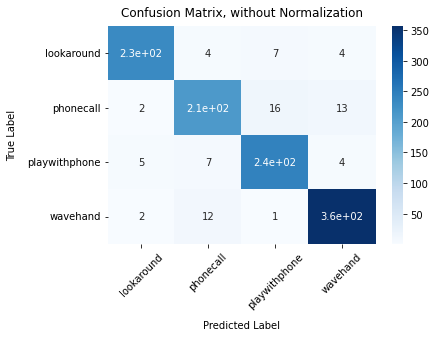

In [34]:
generate_confusion_matrix(y_test, 
                          y_pred_gini_test, 
                          ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                          'Confusion Matrix, without Normalization')

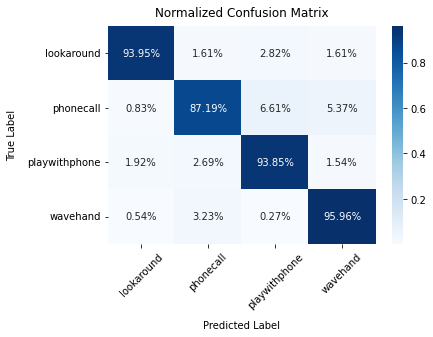

In [35]:
generate_confusion_matrix_norm(y_test,
                               y_pred_gini_test, 
                               ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                               'Normalized Confusion Matrix')

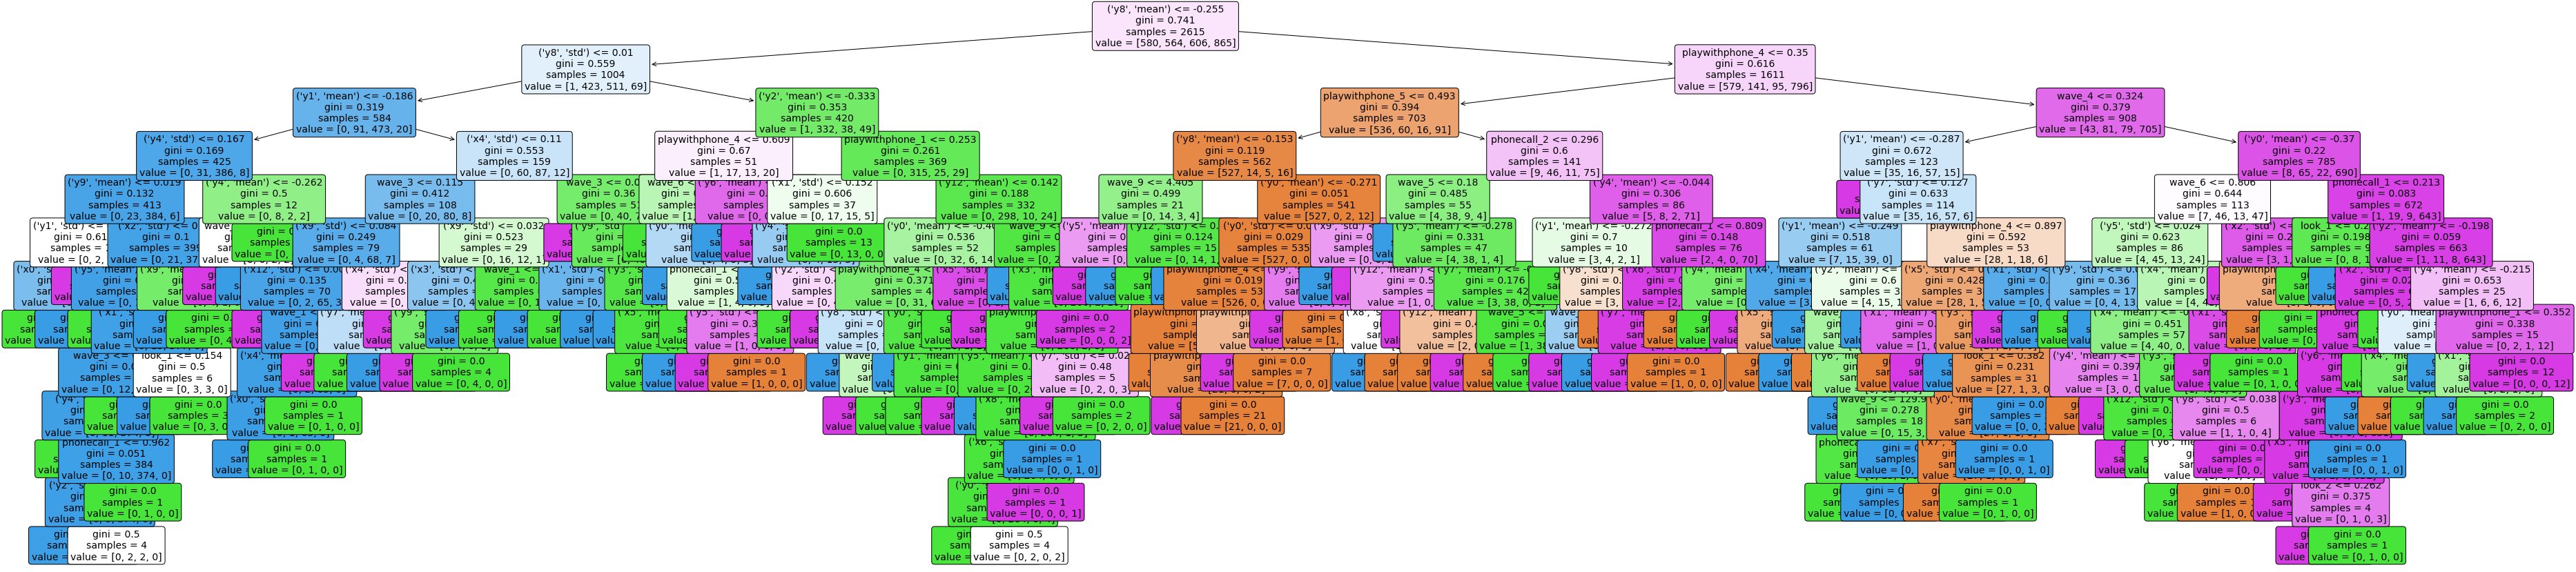

In [36]:
plt.figure(figsize = (65,15))
a = tree.plot_tree(cif_gini, filled=True, rounded=True, fontsize=14, feature_names=feature_df.columns[1:])

In [37]:
Y_test_categ = np.array([to_categ(Yt) for Yt in y_test])
y_pred_gini_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_test])

Y_train_categ = np.array([to_categ(Yt) for Yt in y_train])
y_train_gini_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_train])

In [38]:
# test 
print(classification_report(Y_test_categ, y_pred_gini_categ))

              precision    recall  f1-score   support

     in_need       0.96      0.96      0.96       619
 not_in_need       0.95      0.95      0.95       502

    accuracy                           0.96      1121
   macro avg       0.96      0.96      0.96      1121
weighted avg       0.96      0.96      0.96      1121



In [39]:
# train 
print(classification_report(Y_train_categ, y_train_gini_categ))

              precision    recall  f1-score   support

     in_need       1.00      1.00      1.00      1445
 not_in_need       1.00      1.00      1.00      1170

    accuracy                           1.00      2615
   macro avg       1.00      1.00      1.00      2615
weighted avg       1.00      1.00      1.00      2615



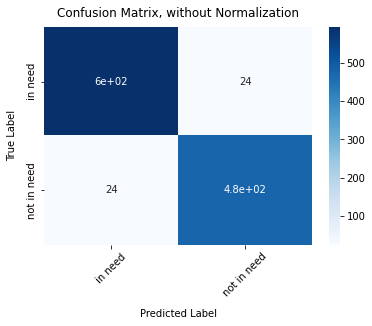

In [40]:
generate_confusion_matrix(Y_test_categ, 
                          y_pred_gini_categ, 
                          ['in need', 'not in need'], 
                          'Confusion Matrix, without Normalization')

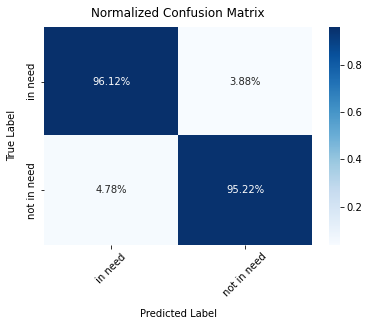

In [41]:
generate_confusion_matrix_norm(Y_test_categ,
                               y_pred_gini_categ, 
                               ['in need', 'not in need'], 
                               'Normalized Confusion Matrix')

## Evaluate with Fixed Train, Val, Test set

In [42]:
feats_df_train = generate_features(train)
feats_df_dev = generate_features(dev)
feats_df_test = generate_features(test)

In [43]:
feats_df_train.shape

(2988, 63)

In [44]:
X_train, y_train = split_X_y(feats_df_train)
X_dev, y_dev = split_X_y(feats_df_dev)
X_test, y_test = split_X_y(feats_df_test)

In [45]:
cif_gini, y_pred_gini_dev, y_pred_gini_train = prediction(X_train, X_dev, y_train, y_dev, 20, 1)

In [46]:
# train set result
print(classification_report(y_train, y_pred_gini_train))

               precision    recall  f1-score   support

   lookaround       1.00      1.00      1.00       655
    phonecall       1.00      1.00      1.00       648
playwithphone       1.00      1.00      1.00       696
     wavehand       1.00      1.00      1.00       989

     accuracy                           1.00      2988
    macro avg       1.00      1.00      1.00      2988
 weighted avg       1.00      1.00      1.00      2988



In [47]:
# dev set result 
print(classification_report(y_test, y_pred_gini_dev))

               precision    recall  f1-score   support

   lookaround       0.83      0.84      0.84        89
    phonecall       0.66      0.70      0.68        86
playwithphone       0.85      0.60      0.71        88
     wavehand       0.74      0.87      0.80       111

     accuracy                           0.76       374
    macro avg       0.77      0.75      0.76       374
 weighted avg       0.77      0.76      0.76       374



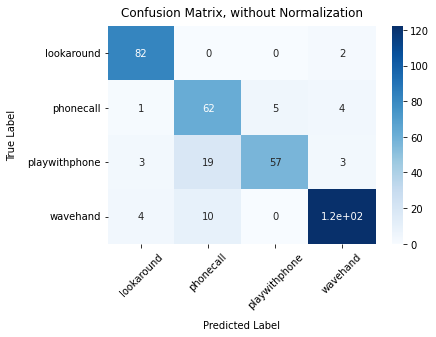

In [48]:
# confusion matrix for dev set
generate_confusion_matrix(y_dev, 
                          y_pred_gini_dev, 
                          ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                          'Confusion Matrix, without Normalization')

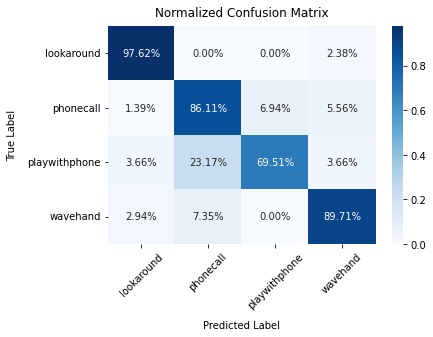

In [49]:
generate_confusion_matrix_norm(y_dev,
                               y_pred_gini_dev, 
                               ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                               'Normalized Confusion Matrix')

In [50]:
y_dev_categ = np.array([to_categ(Yt) for Yt in y_dev])
y_pred_gini_dev_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_dev])

y_train_categ = np.array([to_categ(Yt) for Yt in y_train])
y_pred_gini_train_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_train])

In [51]:
# test 
print(classification_report(y_dev_categ, y_pred_gini_dev_categ))

              precision    recall  f1-score   support

     in_need       0.95      0.95      0.95       220
 not_in_need       0.93      0.93      0.93       154

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



In [52]:
def get_accuracy(X_train, X_dev, y_train, y_dev, max_depth, min_samples_leaf):
  cif_gini, y_pred_gini_dev, y_pred_gini_train = prediction(X_train, X_dev, y_train, y_dev, max_depth, min_samples_leaf)

  y_dev_categ = np.array([to_categ(Yt) for Yt in y_dev])
  y_pred_gini_dev_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_dev])

  y_train_categ = np.array([to_categ(Yt) for Yt in y_train])
  y_pred_gini_train_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_train])

  train_accuracy = classification_report(y_train_categ, y_pred_gini_train_categ, output_dict=True)['accuracy']
  dev_accuracy = classification_report(y_dev_categ, y_pred_gini_dev_categ, output_dict=True)['accuracy']

  # train_accuracy = classification_report(y_train, y_pred_gini_train, output_dict=True)['accuracy']
  # dev_accuracy = classification_report(y_dev, y_pred_gini_dev, output_dict=True)['accuracy']

  return cif_gini, train_accuracy, dev_accuracy

In [53]:
train_accuracy_dict = {}
dev_accuracy_dict = {}
dt_dict = {}

for max_depth in range(1, 26):
  for min_samples_leaf in range(1, 26):
    cif_gini, train_accuracy, dev_accuracy = get_accuracy(X_train, X_dev, y_train, y_dev, max_depth, min_samples_leaf) 
    train_accuracy_dict[(max_depth, min_samples_leaf)] = train_accuracy
    dev_accuracy_dict[(max_depth, min_samples_leaf)] = dev_accuracy
    dt_dict[(max_depth, min_samples_leaf)] = cif_gini

In [54]:
dev_accuracy_dict

{(1, 1): 0.8903743315508021,
 (1, 2): 0.8903743315508021,
 (1, 3): 0.8903743315508021,
 (1, 4): 0.8903743315508021,
 (1, 5): 0.8903743315508021,
 (1, 6): 0.8903743315508021,
 (1, 7): 0.8903743315508021,
 (1, 8): 0.8903743315508021,
 (1, 9): 0.8903743315508021,
 (1, 10): 0.8903743315508021,
 (1, 11): 0.8903743315508021,
 (1, 12): 0.8903743315508021,
 (1, 13): 0.8903743315508021,
 (1, 14): 0.8903743315508021,
 (1, 15): 0.8903743315508021,
 (1, 16): 0.8903743315508021,
 (1, 17): 0.8903743315508021,
 (1, 18): 0.8903743315508021,
 (1, 19): 0.8903743315508021,
 (1, 20): 0.8903743315508021,
 (1, 21): 0.8903743315508021,
 (1, 22): 0.8903743315508021,
 (1, 23): 0.8903743315508021,
 (1, 24): 0.8903743315508021,
 (1, 25): 0.8903743315508021,
 (2, 1): 0.8903743315508021,
 (2, 2): 0.8903743315508021,
 (2, 3): 0.8903743315508021,
 (2, 4): 0.8903743315508021,
 (2, 5): 0.8903743315508021,
 (2, 6): 0.8903743315508021,
 (2, 7): 0.8903743315508021,
 (2, 8): 0.8903743315508021,
 (2, 9): 0.8903743315508021

In [55]:
sorted(dev_accuracy_dict.items(), key=lambda x: x[1], reverse=True)

# best parameters => dev accuracy = 0.9491978609625669: (by in need/ not in need accuracy)
# 1. max_depth=9, min_samples_leaf=1
# 2. max_depth=13, min_samples_leaf=1

# best parameters => dev accuracy = 0.8983957219251337: (by actions accuracy)
# 1. max_depth=9, min_samples_leaf=7

[((9, 1), 0.9491978609625669),
 ((13, 1), 0.9491978609625669),
 ((10, 1), 0.946524064171123),
 ((11, 2), 0.946524064171123),
 ((8, 1), 0.9438502673796791),
 ((8, 2), 0.9438502673796791),
 ((11, 1), 0.9438502673796791),
 ((14, 2), 0.9438502673796791),
 ((15, 2), 0.9438502673796791),
 ((16, 1), 0.9438502673796791),
 ((18, 1), 0.9438502673796791),
 ((19, 1), 0.9438502673796791),
 ((20, 1), 0.9438502673796791),
 ((21, 1), 0.9438502673796791),
 ((22, 1), 0.9438502673796791),
 ((23, 1), 0.9438502673796791),
 ((24, 1), 0.9438502673796791),
 ((25, 1), 0.9438502673796791),
 ((10, 2), 0.9411764705882353),
 ((17, 1), 0.9411764705882353),
 ((8, 5), 0.9385026737967914),
 ((8, 6), 0.9385026737967914),
 ((9, 7), 0.9385026737967914),
 ((12, 2), 0.9385026737967914),
 ((15, 1), 0.9385026737967914),
 ((16, 2), 0.9385026737967914),
 ((8, 4), 0.9358288770053476),
 ((12, 7), 0.9358288770053476),
 ((13, 5), 0.9358288770053476),
 ((7, 1), 0.9331550802139037),
 ((7, 6), 0.9331550802139037),
 ((8, 7), 0.9331550

In [56]:
# evaluation for test set
dt_9_1 = dt_dict[(9, 1)]
y_pred_gini_test = dt_9_1.predict(X_test)

y_test_categ = np.array([to_categ(Yt) for Yt in y_test])
y_pred_gini_test_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_test])

print(classification_report(y_test_categ, y_pred_gini_test_categ))

              precision    recall  f1-score   support

     in_need       0.95      0.96      0.96       200
 not_in_need       0.95      0.94      0.95       174

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



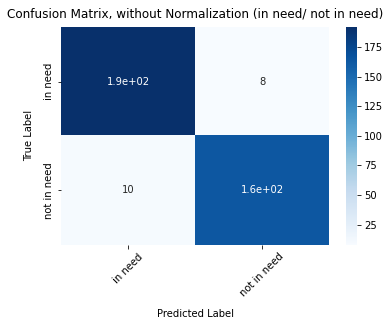

In [57]:
# confusion matrix for dev set
generate_confusion_matrix(y_test_categ, 
                          y_pred_gini_test_categ, 
                          ['in need', 'not in need'], 
                          'Confusion Matrix, without Normalization (in need/ not in need)')

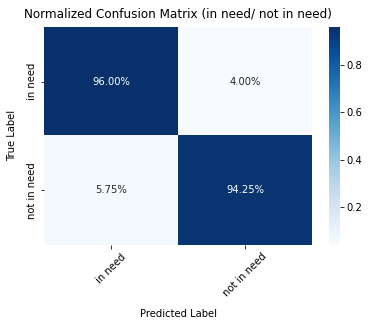

In [58]:
generate_confusion_matrix_norm(y_test_categ,
                               y_pred_gini_test_categ, 
                               ['in need', 'not in need'], 
                               'Normalized Confusion Matrix (in need/ not in need)')

In [59]:
print(classification_report(y_test, y_pred_gini_test))

               precision    recall  f1-score   support

   lookaround       0.97      0.97      0.97        89
    phonecall       0.70      0.88      0.78        86
playwithphone       0.91      0.66      0.76        88
     wavehand       0.93      0.95      0.94       111

     accuracy                           0.87       374
    macro avg       0.88      0.86      0.86       374
 weighted avg       0.88      0.87      0.87       374



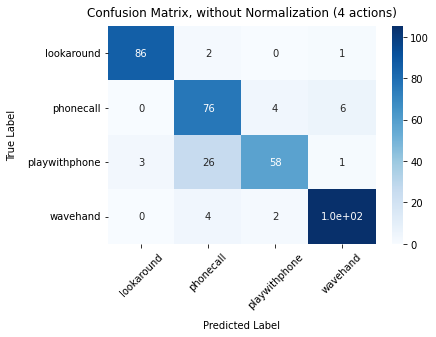

In [60]:
# confusion matrix for dev set
generate_confusion_matrix(y_test, 
                          y_pred_gini_test, 
                          ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                          'Confusion Matrix, without Normalization (4 actions)')

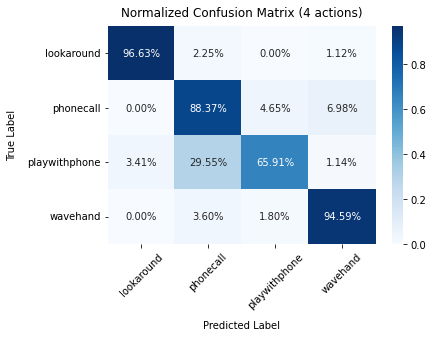

In [61]:
generate_confusion_matrix_norm(y_test,
                               y_pred_gini_test, 
                               ['lookaround', 'phonecall', 'playwithphone', 'wavehand'], 
                               'Normalized Confusion Matrix (4 actions)')

In [62]:
# evaluation for test set
dt_13_1 = dt_dict[(13, 1)]
y_pred_gini_test = dt_13_1.predict(X_test)

y_test_categ = np.array([to_categ(Yt) for Yt in y_test])
y_pred_gini_test_categ = np.array([to_categ(Yt) for Yt in y_pred_gini_test])

print(classification_report(y_test_categ, y_pred_gini_test_categ))

              precision    recall  f1-score   support

     in_need       0.95      0.95      0.95       200
 not_in_need       0.94      0.94      0.94       174

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



In [63]:
print(classification_report(y_test, y_pred_gini_test))

               precision    recall  f1-score   support

   lookaround       0.95      0.97      0.96        89
    phonecall       0.70      0.81      0.75        86
playwithphone       0.80      0.67      0.73        88
     wavehand       0.94      0.92      0.93       111

     accuracy                           0.85       374
    macro avg       0.84      0.84      0.84       374
 weighted avg       0.85      0.85      0.85       374



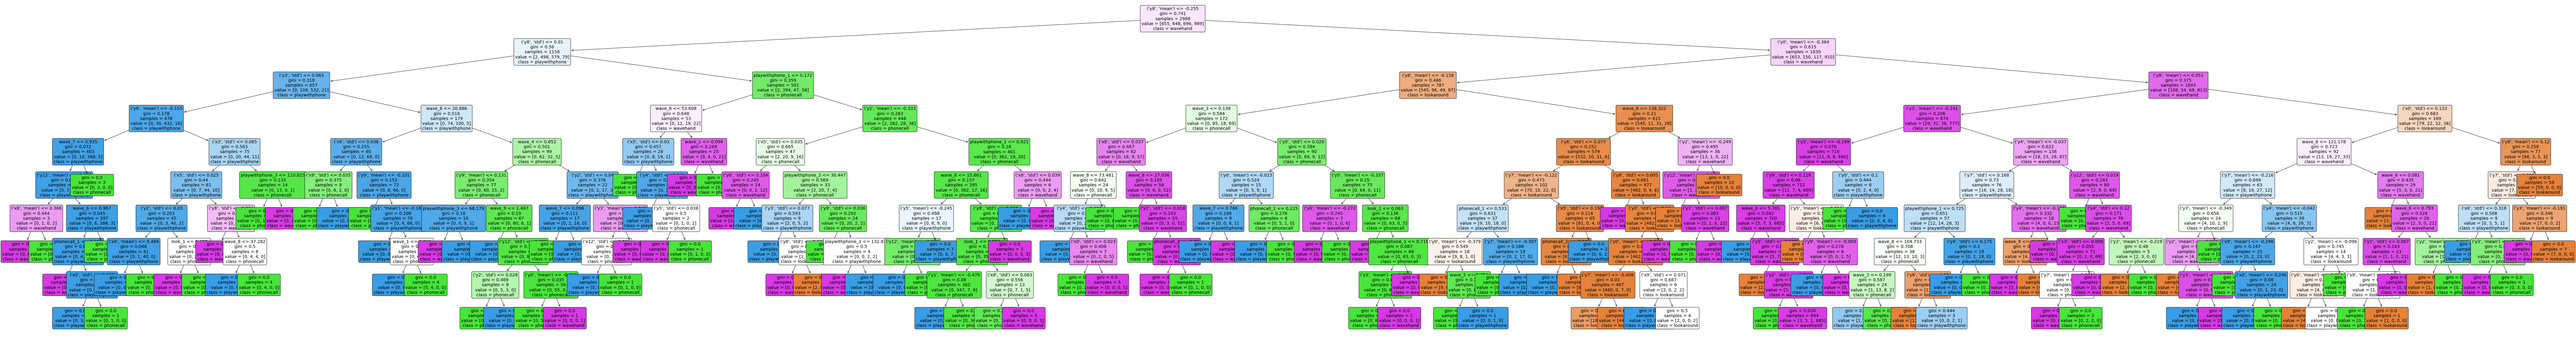

In [73]:
plt.figure(figsize = (150,20))
a = tree.plot_tree(dt_dict[(9, 1)], 
                   filled=True, 
                   rounded=True, 
                   fontsize=14, 
                   feature_names=feature_df.columns[1:], 
                   class_names=['lookaround', 'phonecall', 'playwithphone', 'wavehand'])